In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import torch.nn as nn
import blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Hourly-train.csv')

# Check for rows with null values
print(training_set[training_set.isnull().any(axis=1)])

# Check for columns with null values
print(training_set.isnull().sum())

#any_missing = training_set.isnull().any()
#print(any_missing)
#training_set=training_set.interpolate()

#any_missing = training_set.isnull().any()
#print(any_missing)
training_set = training_set.iloc[:,1:8].values #To substitute with the full columns?



c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


       V1      V2      V3      V4      V5      V6      V7      V8      V9  \
0      H1   605.0   586.0   586.0   559.0   511.0   443.0   422.0   395.0   
1      H2  3124.0  2990.0  2862.0  2809.0  2544.0  2201.0  1996.0  1861.0   
2      H3  1828.0  1806.0  1897.0  1750.0  1679.0  1620.0  1463.0  1342.0   
3      H4  6454.0  6324.0  6075.0  5949.0  5858.0  5579.0  5163.0  4790.0   
4      H5  4263.0  4297.0  4236.0  4080.0  3883.0  3672.0  3248.0  2841.0   
..    ...     ...     ...     ...     ...     ...     ...     ...     ...   
164  H165    49.0    33.0    25.0    20.0    19.0    46.0    62.0   220.0   
165  H166    16.0    39.0    47.0   176.0   548.0   695.0   582.0   630.0   
166  H167    14.0    34.0    34.0   137.0   268.0   281.0   253.0   296.0   
167  H168   623.0   413.0   196.0   184.0    99.0    67.0   101.0   160.0   
168  H169    22.0    11.0    10.0    10.0    10.0    14.0    17.0    86.0   

        V10  ...  V952  V953  V954  V955  V956  V957  V958  V959  V960  V96

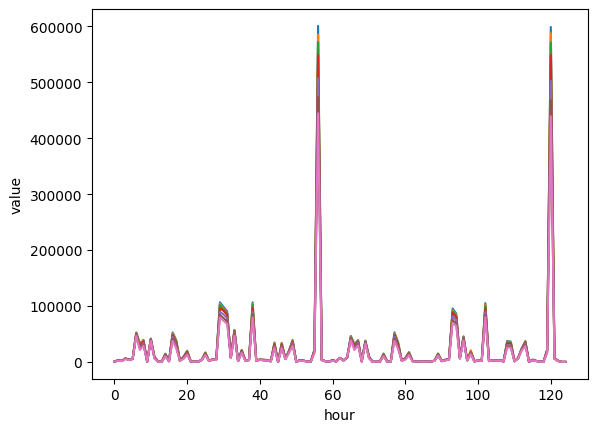

In [2]:
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(training_set[:125])
plt.show()

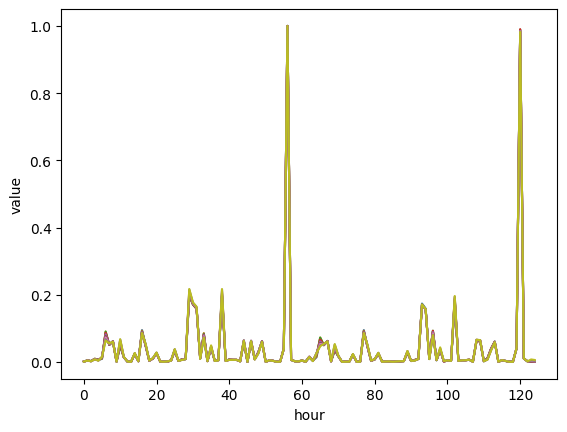

In [3]:
test_set = pd.read_csv('./Datasets/M4-Dataset/Test/Hourly-test.csv')

test_set = test_set.iloc[:,1:10].values
sc = MinMaxScaler()
test_set = sc.fit_transform(test_set)
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(test_set[:125])
plt.show()

In [4]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 32 #it is tau in the paper
x, y = utils.sliding_windows(training_data, seq_length)


train_size=len(y) -36            #like in the paper
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

print('training_data.shape:',training_data.shape)   
print('dataX.shape:',dataX.shape)          
print('dataY.shape:',dataY.shape)
print('TrainX:     ',trainX.shape)               #batch_size, history_length, num_features)
print('TrainY:     ',trainY.shape)
print('TrainX.size(0):',trainX.size(0))
print('train.X.size(2)+10=',trainX.size(2)+10)

training_data.shape: (414, 7)
dataX.shape: torch.Size([381, 32, 7])
dataY.shape: torch.Size([381, 7])
TrainX:      torch.Size([345, 32, 7])
TrainY:      torch.Size([345, 7])
TrainX.size(0): 345
train.X.size(2)+10= 17


In [5]:
sequences=utils.real_seq(training_data,seq_length)
sequences=sequences[:345]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)

float64
torch.Size([345, 7, 32])


# *TRAIN*

In [6]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

In [7]:

path="Models/M4"
utils.create_folder(path)


The new models directory is created!


In [8]:
%%time

embedding_dim=10
batch_size=trainX.size(0)
value_features=1
key_features=1

#extract the number of features
num_features=trainX.size(2)+10

#Hyperparameters
discriminator_lr=0.0005
generator_lr=0.0005
num_epochs=1000
batch_size=115
criterion = nn.MSELoss()

#Initializations
train_set = TensorDataset(trainX, sequences)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) 


D = blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
G=blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))


#Training
g_losses = []
d_losses = []
save=False
for epoch in range(num_epochs):
        g_loss_min=1000000
        d_loss_min=1000000
        g_losses_temp=[]
        d_losses_temp=[]
        for i, (X, Y) in enumerate((train_loader)):
            #print("i:",i)
            #print("X in (train_loader):",X.shape)
            #print("Y:",Y.shape)
            
              
            # Generate fake data
            fake_data = G(X)
            fake_label = torch.zeros(Y.size(0))
            
            # Train the discriminator
            D.zero_grad()
            d_real_loss = criterion(D(Y,X), torch.ones_like(D(Y,X)))
            d_fake_loss = criterion(D(fake_data.detach(),X), torch.zeros_like(D(fake_data.detach(),X)))
            d_loss = d_real_loss + d_fake_loss
            d_losses_temp.append(d_loss.item())
            d_loss.backward(retain_graph=False)
            optimD.step()
            
            # Train the generator
            G.zero_grad()
            g_loss = criterion(D(fake_data,X), torch.ones_like(D(fake_data,X)))

            # Add the moment loss
            g_loss += moment_loss(fake_data, Y)
            #g_loss = moment_loss(fake_data, Y)
            g_losses_temp.append(g_loss.item())

            if(g_loss<g_loss_min and d_loss<d_loss_min and save):
                g_loss_min = g_loss
                d_loss_min = d_loss
                torch.save(G.state_dict(), path+'/generator.pt')
                torch.save(G, path+'/generator_model.pt')
                torch.save(D.state_dict(), path+'/discriminator.pt')
                torch.save(D, path+'/discriminator_model.pt')
                print('Improvement-Detected, model saved')

            g_loss.backward()
            optimG.step()
            
            # Print the losses
            if (i+1) % 1 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % 
                    (epoch+1, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))
        g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
        d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))

RuntimeError: Given groups=1, weight of size [32, 18, 1], expected input[115, 24, 32] to have 18 channels, but got 24 channels instead

End-training Generator Loss: tensor(0.2962)
End-training Discriminator Loss: tensor(0.4998)


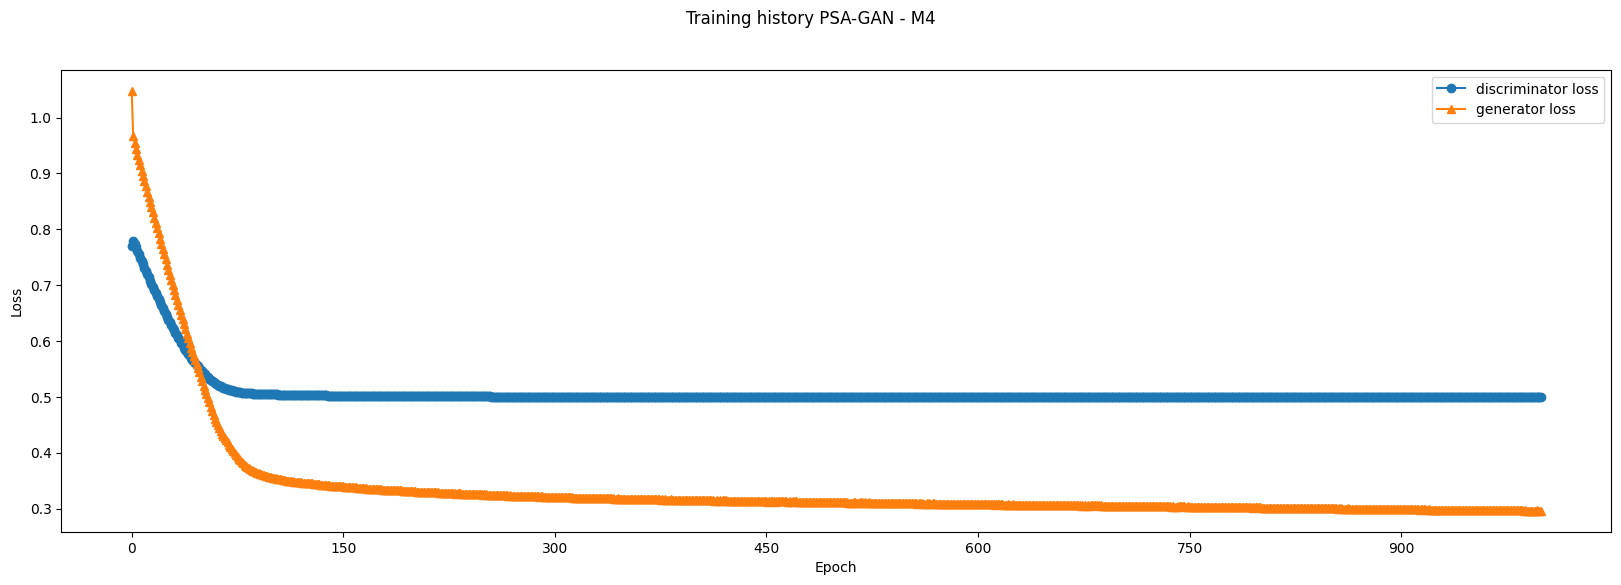

In [ ]:

utils.plot_training_history('PSA-GAN - M4',d_losses, g_losses)


In [ ]:
with torch.no_grad():
    
    generated_series = G(dataX[:batch_size]) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.detach().numpy()
    #print("generated_series: ",generated_series.shape)


generated_series:  torch.Size([115, 32, 1])


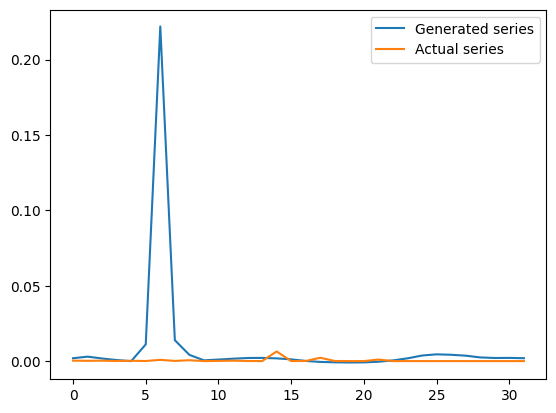

Gamma of Self-Attention: Parameter containing:
tensor([0.0174], requires_grad=True)


In [ ]:
# Plot the generated time series samples

plt.figure()
#for i in range(trainX.size(0)):
#    plt.plot(generated_series[i], label='Generated series')
#plt.plot(utils.scale(generated_series[batch_size-1]), label='Generated scaled series')
plt.plot((generated_series[batch_size-1]), label='Generated series')
plt.plot(training_data[batch_size+seq_length-1:batch_size+2*seq_length-1], label='Actual series')
#sequences=sequences.permute(0,2,1)
#plt.plot(sequences[batch_size-1],label="label series")
plt.legend()
plt.show()

#print("Context FID:",fid_score)
print("Gamma Self-Attention:",G.main.attn.gamma)

In [ ]:
with torch.no_grad():
    
    generated_series = G(dataX[:batch_size]) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.detach().numpy()
    #print("generated_series: ",generated_series.shape)

generated_series:  torch.Size([115, 32, 1])


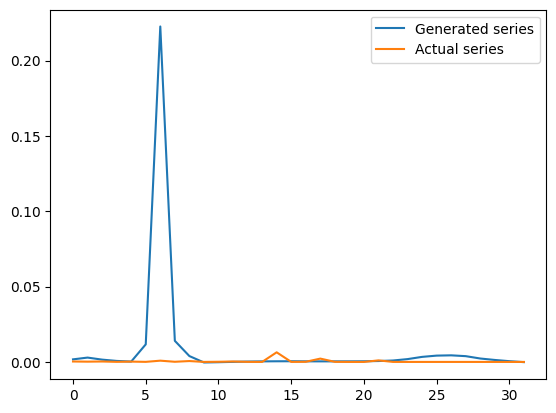

Gamma of Self-Attention: Parameter containing:
tensor([0.0174], requires_grad=True)


In [ ]:
# Plot the generated time series samples

plt.figure()
#for i in range(trainX.size(0)):
#    plt.plot(generated_series[i], label='Generated series')
#plt.plot(utils.scale(generated_series[batch_size-1]), label='Generated scaled series')
plt.plot((generated_series[batch_size-1]), label='Generated series')
plt.plot(training_data[batch_size+seq_length-1:batch_size+2*seq_length-1], label='Actual series')
#sequences=sequences.permute(0,2,1)
#plt.plot(sequences[batch_size-1],label="label series")
plt.legend()
plt.show()

#print("Context FID:",fid_score)
print("Gamma of Self-Attention:",G.main.attn.gamma)